## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [4]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["KO","T","NVDA"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df


# Display sample data
df_ticker.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,43.22,43.500,43.10,51614,43.16,14259973,43.309815,KO
2017-05-02 04:00:00+00:00,43.39,43.440,43.16,53704,43.22,12801453,43.332452,KO
2017-05-03 04:00:00+00:00,43.32,43.485,43.15,49212,43.33,11266228,43.352508,KO
2017-05-04 04:00:00+00:00,43.66,43.810,43.40,46644,43.42,11128331,43.633275,KO
2017-05-05 04:00:00+00:00,43.69,43.840,43.56,38312,43.79,9322466,43.674892,KO


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [5]:
# Reorganize the DataFrame
# Separate ticker data
#T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
ticker_one = df_ticker[df_ticker["symbol"]==tickers[0]].drop("symbol", axis=1)
ticker_two = df_ticker[df_ticker["symbol"]==tickers[1]].drop("symbol", axis=1)
ticker_three = df_ticker[df_ticker["symbol"]==tickers[2]].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([ticker_one, ticker_two, ticker_three], axis=1, keys=[tickers[0],tickers[1],tickers[2]])

# Display sample data
df_ticker.head()

KO                                              \
                           close    high    low trade_count   open    volume   
timestamp                                                                      
2017-05-01 04:00:00+00:00  43.22  43.500  43.10       51614  43.16  14259973   
2017-05-02 04:00:00+00:00  43.39  43.440  43.16       53704  43.22  12801453   
2017-05-03 04:00:00+00:00  43.32  43.485  43.15       49212  43.33  11266228   
2017-05-04 04:00:00+00:00  43.66  43.810  43.40       46644  43.42  11128331   
2017-05-05 04:00:00+00:00  43.69  43.840  43.56       38312  43.79   9322466   

                                          T                ...         \
                                vwap  close   high    low  ...   open   
timestamp                                                  ...          
2017-05-01 04:00:00+00:00  43.309815  39.10  39.70  39.06  ...  39.68   
2017-05-02 04:00:00+00:00  43.332452  38.95  39.22  38.88  ...  39.14   
2017-05-03 04:00:00+00:00  43.352508  38.40  38.98  38.15  ...  38.94   
2017-05-04 04:00:00+00:00  43.633275  38.01  38.41  37.63  ...  38.41   
2017-05-05 04:00:00+00:00  43.674892  38.56  38.71  38.03  ...  38.08   

                                                  NVDA                    \
                             volume       vwap   close      high     low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  27137598  39.283136  106.64  106.8500  104.45   
2017-05-02 04:00:00+00:00  26346738  38.996146  103.48  105.5955  102.56   
2017-05-03 04:00:00+00:00  36621125  38.426498  104.25  104.6400  102.60   
2017-05-04 04:00:00+00:00  32681751  37.969998  103.85  104.9500  103.53   
2017-05-05 04:00:00+00:00  23262074  38.426797  103.86  104.1500  102.75   

                                                                     
                          trade_count    open    volume        vwap  
timestamp                                                            
2017-05-01 04:00:00+00:00       49786  104.74   7943207  105.817462  
2017-05-02 04:00:00+00:00       89765  105.55  16260487  103.682901  
2017-05-03 04:00:00+00:00       54087  103.20   8707151  103.756509  
2017-05-04 04:00:00+00:00       36348  104.50   5503363  104.048760  
2017-05-05 04:00:00+00:00       39185  103.38   6040065  103.540482  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [6]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_even_dist = MCSimulation(df_ticker, weights=[1/3,1/3,1/3], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

KO                                              \
                           close    high    low trade_count   open    volume   
timestamp                                                                      
2017-05-01 04:00:00+00:00  43.22  43.500  43.10       51614  43.16  14259973   
2017-05-02 04:00:00+00:00  43.39  43.440  43.16       53704  43.22  12801453   
2017-05-03 04:00:00+00:00  43.32  43.485  43.15       49212  43.33  11266228   
2017-05-04 04:00:00+00:00  43.66  43.810  43.40       46644  43.42  11128331   
2017-05-05 04:00:00+00:00  43.69  43.840  43.56       38312  43.79   9322466   

                                                       T         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  43.309815          NaN  39.10  39.70  ...   
2017-05-02 04:00:00+00:00  43.332452     0.003933  38.95  39.22  ...   
2017-05-03 04:00:00+00:00  43.352508    -0.001613  38.40  38.98  ...   
2017-05-04 04:00:00+00:00  43.633275     0.007849  38.01  38.41  ...   
2017-05-05 04:00:00+00:00  43.674892     0.000687  38.56  38.71  ...   

                                                     NVDA                    \
                                vwap daily_return   close      high     low   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.283136          NaN  106.64  106.8500  104.45   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  103.48  105.5955  102.56   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  104.25  104.6400  102.60   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  103.85  104.9500  103.53   
2017-05-05 04:00:00+00:00  38.426797     0.014470  103.86  104.1500  102.75   

                                                                     \
                          trade_count    open    volume        vwap   
timestamp                                                             
2017-05-01 04:00:00+00:00       49786  104.74   7943207  105.817462   
2017-05-02 04:00:00+00:00       89765  105.55  16260487  103.682901   
2017-05-03 04:00:00+00:00       54087  103.20   8707151  103.756509   
2017-05-04 04:00:00+00:00       36348  104.50   5503363  104.048760   
2017-05-05 04:00:00+00:00       39185  103.38   6040065  103.540482   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00    -0.029632  
2017-05-03 04:00:00+00:00     0.007441  
2017-05-04 04:00:00+00:00    -0.003837  
2017-05-05 04:00:00+00:00     0.000096  

[5 rows x 24 columns]

/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

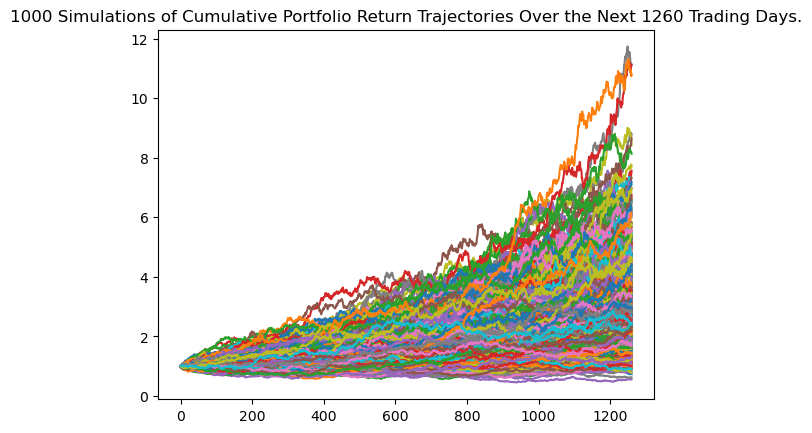

In [7]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.plot_simulation()


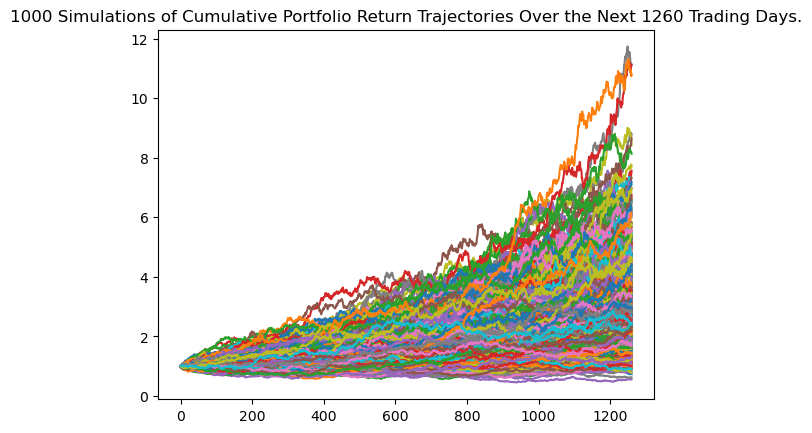

In [8]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_fiveyear_sim_plot.png', bbox_inches='tight')

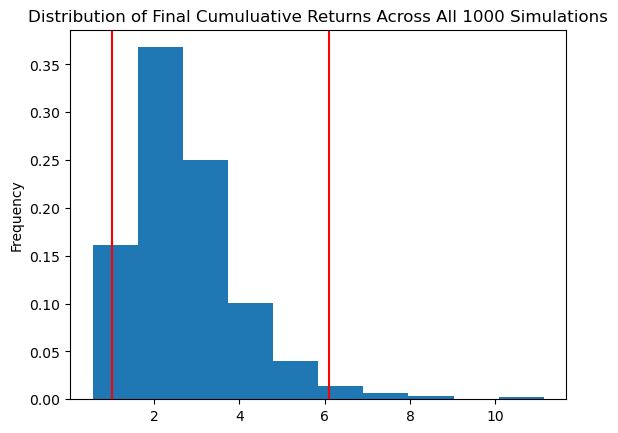

In [9]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_equal = MC_even_dist.simulated_return.iloc[-1].describe()
ci_series_equal = MC_even_dist.confidence_interval
ci_series_equal.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_equal = pd.concat([summary_metrics_equal, ci_series_equal], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_equal)

count           1000.000000
mean               2.757111
std                1.326061
min                0.563136
25%                1.872027
50%                2.484104
75%                3.359000
max               11.133949
95% CI Lower       1.009756
95% CI Upper       6.095470
Name: 1260, dtype: float64


In [11]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_equal = round((summary_df_equal['95% CI Lower'] * initial_investment), 2)
upper_bound_equal = round((summary_df_equal['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_equal} and ${upper_bound_equal}.")

sharpe_equal = summary_df_equal['mean']/summary_df_equal['std']
print(f"this is your sharpe: {round(sharpe_equal, 2)}, you make {round(sharpe_equal,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $15146.34 and $91432.05.
this is your sharpe: 2.08, you make 2.08 units of return for every 1 unit of risk


### Simulate five year portfolio growth with 60% ticker_two stock

In [12]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy = MCSimulation(df_ticker, weights=[.20,.60,.20], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_two_heavy.portfolio_data.head()

KO                                              \
                           close    high    low trade_count   open    volume   
timestamp                                                                      
2017-05-01 04:00:00+00:00  43.22  43.500  43.10       51614  43.16  14259973   
2017-05-02 04:00:00+00:00  43.39  43.440  43.16       53704  43.22  12801453   
2017-05-03 04:00:00+00:00  43.32  43.485  43.15       49212  43.33  11266228   
2017-05-04 04:00:00+00:00  43.66  43.810  43.40       46644  43.42  11128331   
2017-05-05 04:00:00+00:00  43.69  43.840  43.56       38312  43.79   9322466   

                                                       T         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  43.309815          NaN  39.10  39.70  ...   
2017-05-02 04:00:00+00:00  43.332452     0.003933  38.95  39.22  ...   
2017-05-03 04:00:00+00:00  43.352508    -0.001613  38.40  38.98  ...   
2017-05-04 04:00:00+00:00  43.633275     0.007849  38.01  38.41  ...   
2017-05-05 04:00:00+00:00  43.674892     0.000687  38.56  38.71  ...   

                                                     NVDA                    \
                                vwap daily_return   close      high     low   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.283136          NaN  106.64  106.8500  104.45   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  103.48  105.5955  102.56   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  104.25  104.6400  102.60   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  103.85  104.9500  103.53   
2017-05-05 04:00:00+00:00  38.426797     0.014470  103.86  104.1500  102.75   

                                                                     \
                          trade_count    open    volume        vwap   
timestamp                                                             
2017-05-01 04:00:00+00:00       49786  104.74   7943207  105.817462   
2017-05-02 04:00:00+00:00       89765  105.55  16260487  103.682901   
2017-05-03 04:00:00+00:00       54087  103.20   8707151  103.756509   
2017-05-04 04:00:00+00:00       36348  104.50   5503363  104.048760   
2017-05-05 04:00:00+00:00       39185  103.38   6040065  103.540482   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00    -0.029632  
2017-05-03 04:00:00+00:00     0.007441  
2017-05-04 04:00:00+00:00    -0.003837  
2017-05-05 04:00:00+00:00     0.000096  

[5 rows x 24 columns]

/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

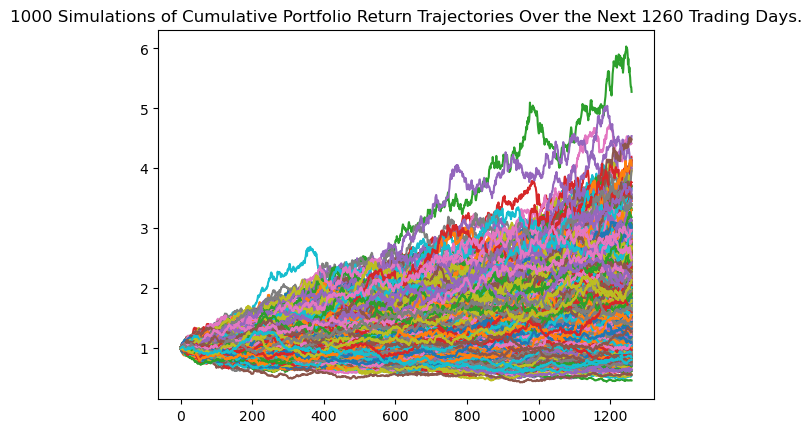

In [13]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy.plot_simulation()

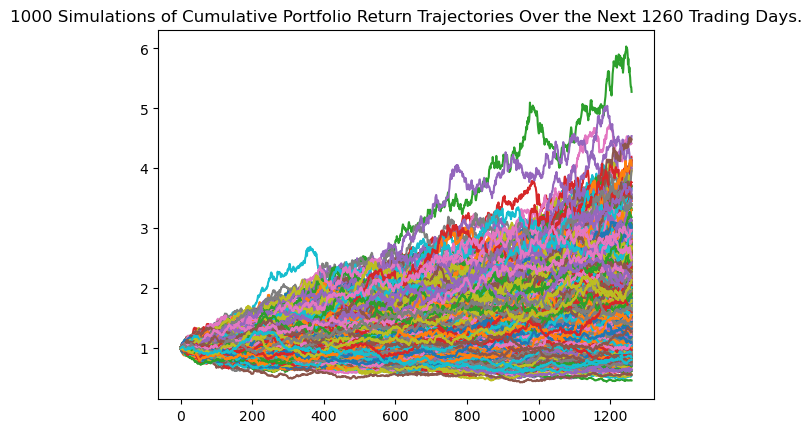

In [14]:
# Plot simulation outcomes
line_plot = MC_ticker_two_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_ATT_fiveyear_sim_plot.png', bbox_inches='tight')

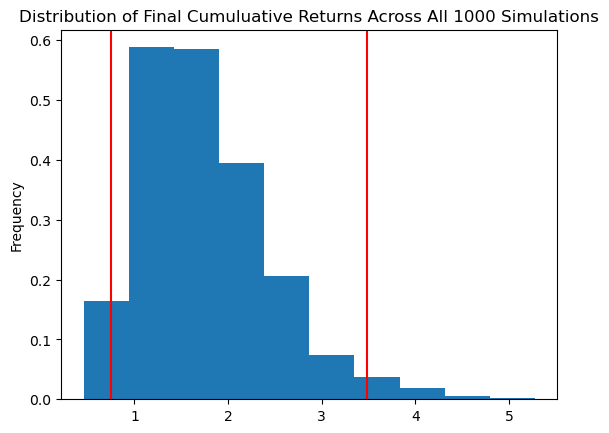

In [15]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_two_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_att_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_two_heavy = MC_ticker_two_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_two_heavy = MC_ticker_two_heavy.confidence_interval
ci_series_ticker_two_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_two_heavy = pd.concat([summary_metrics_ticker_two_heavy, ci_series_ticker_two_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_two_heavy)

count           1000.000000
mean               1.751788
std                0.686555
min                0.460668
25%                1.253218
50%                1.655761
75%                2.114368
max                5.275126
95% CI Lower       0.748799
95% CI Upper       3.486337
Name: 1260, dtype: float64


In [17]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_two_heavy} and ${upper_bound_ticker_two_heavy}.")


There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $11231.98 and $52295.06.


### Simulate five year portfolio growth with 60% ticker_three stock

In [18]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_ticker_three_heavy = MCSimulation(df_ticker, weights=[.20,.20,.60], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Printing the simulation input data
MC_ticker_three_heavy.portfolio_data.head()

KO                                              \
                           close    high    low trade_count   open    volume   
timestamp                                                                      
2017-05-01 04:00:00+00:00  43.22  43.500  43.10       51614  43.16  14259973   
2017-05-02 04:00:00+00:00  43.39  43.440  43.16       53704  43.22  12801453   
2017-05-03 04:00:00+00:00  43.32  43.485  43.15       49212  43.33  11266228   
2017-05-04 04:00:00+00:00  43.66  43.810  43.40       46644  43.42  11128331   
2017-05-05 04:00:00+00:00  43.69  43.840  43.56       38312  43.79   9322466   

                                                       T         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  43.309815          NaN  39.10  39.70  ...   
2017-05-02 04:00:00+00:00  43.332452     0.003933  38.95  39.22  ...   
2017-05-03 04:00:00+00:00  43.352508    -0.001613  38.40  38.98  ...   
2017-05-04 04:00:00+00:00  43.633275     0.007849  38.01  38.41  ...   
2017-05-05 04:00:00+00:00  43.674892     0.000687  38.56  38.71  ...   

                                                     NVDA                    \
                                vwap daily_return   close      high     low   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.283136          NaN  106.64  106.8500  104.45   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  103.48  105.5955  102.56   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  104.25  104.6400  102.60   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  103.85  104.9500  103.53   
2017-05-05 04:00:00+00:00  38.426797     0.014470  103.86  104.1500  102.75   

                                                                     \
                          trade_count    open    volume        vwap   
timestamp                                                             
2017-05-01 04:00:00+00:00       49786  104.74   7943207  105.817462   
2017-05-02 04:00:00+00:00       89765  105.55  16260487  103.682901   
2017-05-03 04:00:00+00:00       54087  103.20   8707151  103.756509   
2017-05-04 04:00:00+00:00       36348  104.50   5503363  104.048760   
2017-05-05 04:00:00+00:00       39185  103.38   6040065  103.540482   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00    -0.029632  
2017-05-03 04:00:00+00:00     0.007441  
2017-05-04 04:00:00+00:00    -0.003837  
2017-05-05 04:00:00+00:00     0.000096  

[5 rows x 24 columns]

/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

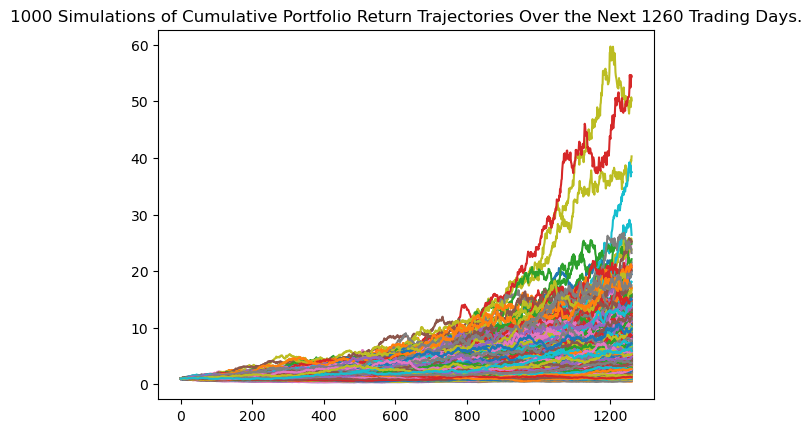

In [19]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_three_heavy.plot_simulation()

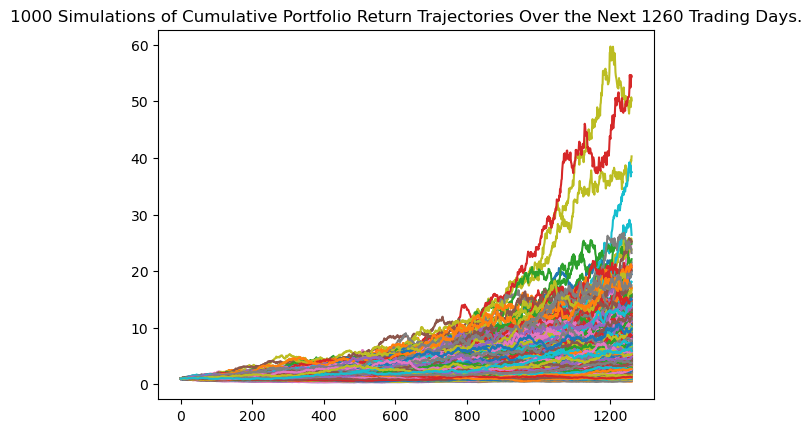

In [20]:
# Plot simulation outcomes
line_plot = MC_ticker_three_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_xom_fiveyear_sim_plot.png', bbox_inches='tight')

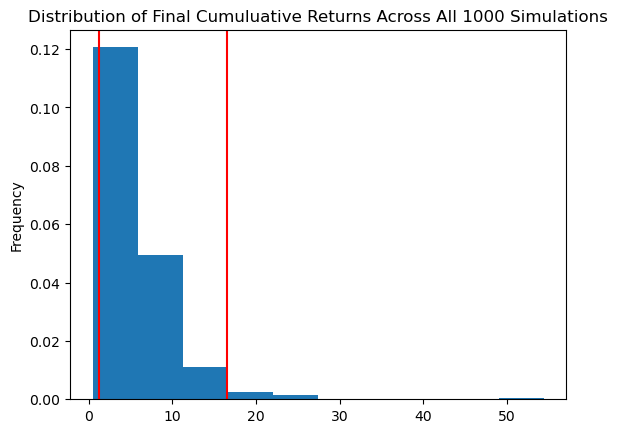

In [21]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_three_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_three_heavy = MC_ticker_three_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_three_heavy = MC_ticker_three_heavy.confidence_interval
ci_series_ticker_three_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_three_heavy = pd.concat([summary_metrics_ticker_three_heavy, ci_series_ticker_three_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_three_heavy)

count           1000.000000
mean               5.777150
std                4.631647
min                0.478146
25%                2.969513
50%                4.705928
75%                7.049889
max               54.372608
95% CI Lower       1.215790
95% CI Upper      16.557577
Name: 1260, dtype: float64


In [23]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_three_heavy} and ${upper_bound_ticker_three_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $18236.85 and $248363.65.


### Simulate five year portfolio growth with 60% ticker_one stock

In [24]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_ticker_one_heavy = MCSimulation(df_ticker, weights=[.60,.20,.20], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_one_heavy.portfolio_data.head()

KO                                              \
                           close    high    low trade_count   open    volume   
timestamp                                                                      
2017-05-01 04:00:00+00:00  43.22  43.500  43.10       51614  43.16  14259973   
2017-05-02 04:00:00+00:00  43.39  43.440  43.16       53704  43.22  12801453   
2017-05-03 04:00:00+00:00  43.32  43.485  43.15       49212  43.33  11266228   
2017-05-04 04:00:00+00:00  43.66  43.810  43.40       46644  43.42  11128331   
2017-05-05 04:00:00+00:00  43.69  43.840  43.56       38312  43.79   9322466   

                                                       T         ...  \
                                vwap daily_return  close   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  43.309815          NaN  39.10  39.70  ...   
2017-05-02 04:00:00+00:00  43.332452     0.003933  38.95  39.22  ...   
2017-05-03 04:00:00+00:00  43.352508    -0.001613  38.40  38.98  ...   
2017-05-04 04:00:00+00:00  43.633275     0.007849  38.01  38.41  ...   
2017-05-05 04:00:00+00:00  43.674892     0.000687  38.56  38.71  ...   

                                                     NVDA                    \
                                vwap daily_return   close      high     low   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.283136          NaN  106.64  106.8500  104.45   
2017-05-02 04:00:00+00:00  38.996146    -0.003836  103.48  105.5955  102.56   
2017-05-03 04:00:00+00:00  38.426498    -0.014121  104.25  104.6400  102.60   
2017-05-04 04:00:00+00:00  37.969998    -0.010156  103.85  104.9500  103.53   
2017-05-05 04:00:00+00:00  38.426797     0.014470  103.86  104.1500  102.75   

                                                                     \
                          trade_count    open    volume        vwap   
timestamp                                                             
2017-05-01 04:00:00+00:00       49786  104.74   7943207  105.817462   
2017-05-02 04:00:00+00:00       89765  105.55  16260487  103.682901   
2017-05-03 04:00:00+00:00       54087  103.20   8707151  103.756509   
2017-05-04 04:00:00+00:00       36348  104.50   5503363  104.048760   
2017-05-05 04:00:00+00:00       39185  103.38   6040065  103.540482   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00    -0.029632  
2017-05-03 04:00:00+00:00     0.007441  
2017-05-04 04:00:00+00:00    -0.003837  
2017-05-05 04:00:00+00:00     0.000096  

[5 rows x 24 columns]

/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/joshbazz/Desktop/Bootcamp/Monte-Carlo-Simulator/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

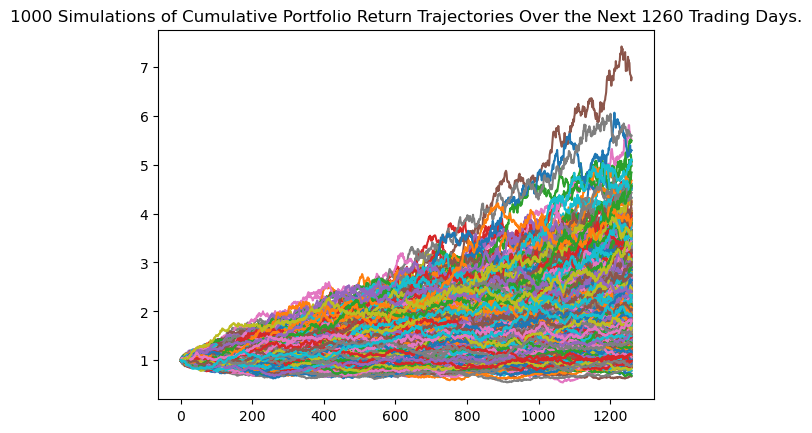

In [25]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_one_heavy.plot_simulation()

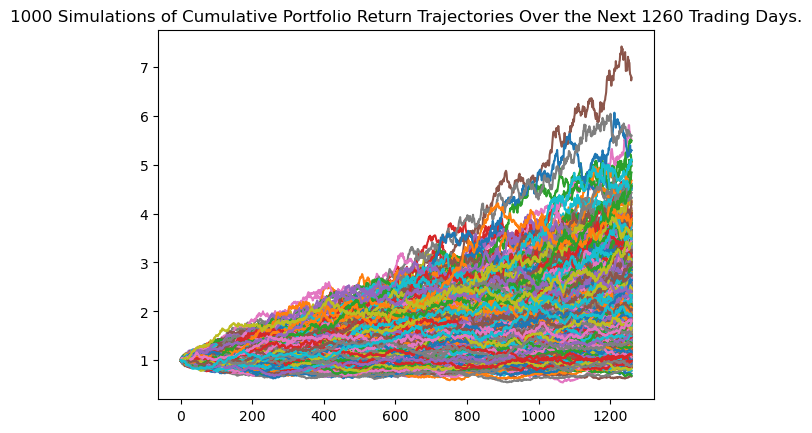

In [26]:
# Plot simulation outcomes
line_plot = MC_ticker_one_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_nike_fiveyear_sim_plot.png', bbox_inches='tight')

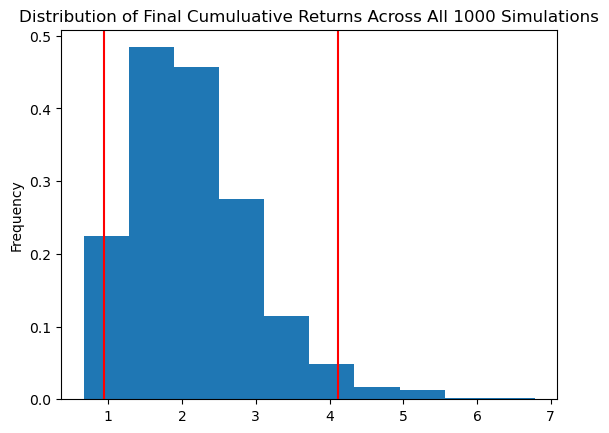

In [27]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_one_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_one_heavy = MC_ticker_one_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_one_heavy = MC_ticker_one_heavy.confidence_interval
ci_series_ticker_one_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_one_heavy = pd.concat([summary_metrics_ticker_one_heavy, ci_series_ticker_one_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_one_heavy)

count           1000.000000
mean               2.151542
std                0.844336
min                0.669455
25%                1.516120
50%                2.018769
75%                2.618956
max                6.784172
95% CI Lower       0.940678
95% CI Upper       4.111322
Name: 1260, dtype: float64


In [29]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_one_heavy} and ${upper_bound_ticker_one_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $14110.17 and $61669.84.


### Summarize findings across all 4 simulations

In [30]:
# set equal portfolio metrics
risk_reward_equal = round((upper_bound_equal - initial_investment)/abs(lower_bound_equal - initial_investment), 2)
sharpe = summary_df_equal['mean']/summary_df_equal['std']
risk_adjusted_efficiency_equal = round((risk_reward_equal / sharpe), 2)

# set heavy ticker_one metrics
risk_reward_ticker_one_heavy = round((upper_bound_ticker_one_heavy - initial_investment)/abs(lower_bound_ticker_one_heavy - initial_investment), 2)
sharpe_ticker_one_heavy = summary_df_ticker_one_heavy['mean']/summary_df_ticker_one_heavy['std']
risk_adjusted_efficiency_ticker_one_heavy = round((risk_reward_ticker_one_heavy / sharpe_ticker_one_heavy), 2)

# set heavy ticker_two metrics
risk_reward_ticker_two_heavy = round((upper_bound_ticker_two_heavy - initial_investment)/abs(lower_bound_ticker_two_heavy - initial_investment), 2)
sharpe_ticker_two_heavy = summary_df_ticker_two_heavy['mean']/summary_df_ticker_two_heavy['std']
risk_adjusted_efficiency_ticker_two_heavy = round((risk_reward_ticker_two_heavy / sharpe_ticker_two_heavy), 2)

# set heavy ticker_three metrics
risk_reward_ticker_three_heavy = round((upper_bound_ticker_three_heavy - initial_investment)/abs(lower_bound_ticker_three_heavy - initial_investment), 2)
sharpe_ticker_three_heavy = summary_df_ticker_three_heavy['mean']/summary_df_ticker_three_heavy['std']
risk_adjusted_efficiency_ticker_three_heavy = round((risk_reward_ticker_three_heavy / sharpe_ticker_three_heavy), 2)

In [31]:
print(f"Initial Investment: ${initial_investment}")

print("--------------")
print(f'Upper and Lower Bounds of Equal Weighted: ${upper_bound_equal} and ${lower_bound_equal}')
print(f"Equal Weighted Max Profit: ${upper_bound_equal - initial_investment}")
print(f"Equal Weighted Max Loss: $ {lower_bound_equal - initial_investment}")
print(f"Equal Weighted Risk-Reward Ratio: {risk_reward_equal}")
print(f"Equal Weighted Simulation Sharpe: {round(sharpe, 2)}")
print(f"Equal Weighted Risk-Adjusted Efficiency: {risk_adjusted_efficiency_equal}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[0]} Weighted: ${upper_bound_ticker_one_heavy} and ${lower_bound_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Profit: ${upper_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} max loss: $ {lower_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} Risk-Reward Ratio: {risk_reward_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Simulation Sharpe: {round(sharpe_ticker_one_heavy, 2)}")
print(f"Heavy {tickers[0]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_one_heavy}")

print("--------------")

print(f"Upper and Lower bounds of Heavy {tickers[1]} Weighted: ${upper_bound_ticker_two_heavy} and ${lower_bound_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Max Profit: ${upper_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Max Loss: $ {lower_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Risk-Reward Ratio: {risk_reward_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Simulation Sharpe: {round(sharpe_ticker_two_heavy, 2)}")
print(f"Heavy {tickers[1]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_two_heavy}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[2]} Weighted: ${upper_bound_ticker_three_heavy} and ${lower_bound_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Max Profit: ${upper_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Max Loss: $ {lower_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Risk-Reward Ratio: {risk_reward_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Simulation Sharpe: {round(sharpe_ticker_three_heavy, 2)}")
print(f"Heavy {tickers[2]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_three_heavy}")

Initial Investment: $15000
--------------
Upper and Lower Bounds of Equal Weighted: $91432.05 and $15146.34
Equal Weighted Max Profit: $76432.05
Equal Weighted Max Loss: $ 146.34000000000015
Equal Weighted Risk-Reward Ratio: 522.29
Equal Weighted Simulation Sharpe: 2.08
Equal Weighted Risk-Adjusted Efficiency: 251.2
--------------
Upper and Lower Bounds of Heavy KO Weighted: $61669.84 and $14110.17
Heavy KO Profit: $46669.84
Heavy KO max loss: $ -889.8299999999999
Heavy KO Risk-Reward Ratio: 52.45
Heavy KO Simulation Sharpe: 2.55
Heavy KO Risk-Adjusted Efficiency: 20.58
--------------
Upper and Lower bounds of Heavy T Weighted: $52295.06 and $11231.98
Heavy T Max Profit: $37295.06
Heavy T Max Loss: $ -3768.0200000000004
Heavy T Risk-Reward Ratio: 9.9
Heavy T Simulation Sharpe: 2.55
Heavy T Risk-Adjusted Efficiency: 3.88
--------------
Upper and Lower Bounds of Heavy NVDA Weighted: $248363.65 and $18236.85
Heavy NVDA Max Profit: $233363.65
Heavy NVDA Max Loss: $ 3236.8499999999985
Heavy